In [ ]:
# ライブラリの読み込みとGPUの設定
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [ ]:
# 事前処理
train_datagen = ImageDataGenerator(
    tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

In [ ]:
# データジェネレータの作成
from google.colab import drive
drive.mount('/content/drive')
train_dir = '/content/drive/MyDrive/Face_Image'  # トレーニングデータセットのディレクトリパス

batch_size = 128  # バッチサイズ
class_mode = 'categorical'  # クラスモード

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=class_mode,
    subset='training'
)

test_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=class_mode,
    subset='validation'
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 14566 images belonging to 3 classes.
Found 3639 images belonging to 3 classes.


In [ ]:
# 新しいモデルの構築
num_classes = 3

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128, activation='relu',  kernel_regularizer=l2(10.0)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # num_classesはクラス数に置き換える

In [ ]:
# 事前学習済みモデルの重みを固定
base_model.trainable = False

# モデルのコンパイル
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStoppingコールバックの定義
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/15
113/113 [==============================] - 238s 2s/step - loss: 377.8071 - accuracy: 0.7191 - val_loss: 0.7229 - val_accuracy: 0.9300
Epoch 2/15
113/113 [==============================] - 230s 2s/step - loss: 0.6702 - accuracy: 0.8503 - val_loss: 0.4945 - val_accuracy: 0.9392
Epoch 3/15
113/113 [==============================] - 231s 2s/step - loss: 0.5924 - accuracy: 0.8748 - val_loss: 0.4160 - val_accuracy: 0.9623
Epoch 4/15
113/113 [==============================] - 231s 2s/step - loss: 0.5272 - accuracy: 0.8910 - val_loss: 0.3680 - val_accuracy: 0.9581
Epoch 5/15
113/113 [==============================] - 230s 2s/step - loss: 0.5306 - accuracy: 0.8912 - val_loss: 0.3551 - val_accuracy: 0.9718
Epoch 6/15
113/113 [==============================] - 230s 2s/step - loss: 0.5463 - accuracy: 0.8904 - val_loss: 0.3066 - val_accuracy: 0.9738
Epoch 7/15
113/113 [==============================] - 230s 2s/step - loss: 0.4925 - accuracy: 0.9023 - val_loss: 0.8654 - val_accuracy: 0.88

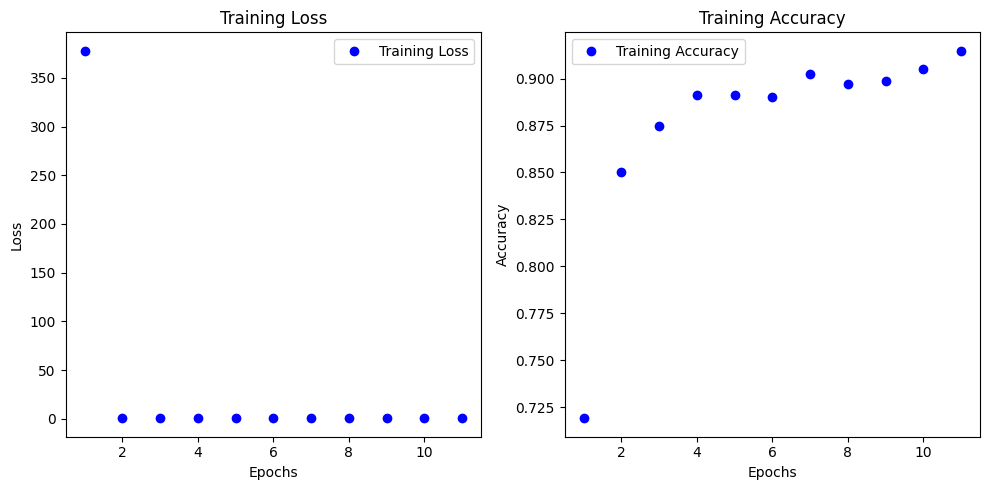

In [ ]:
# モデルのトレーニング
epochs = 15  # エポック数

history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
     callbacks=[early_stopping]
)


In [ ]:
# モデルの評価
test_loss, test_accuracy = model.evaluate(test_generator)

print(test_loss)
print(test_accuracy)

29/29 [==============================] - 47s 2s/step - loss: 0.3074 - accuracy: 0.9717
0.30738911032676697
0.9716955423355103


In [ ]:
# モデルをHDF5形式で保存
model.save('model.h5')

In [ ]:
import tensorflow as tf

# モデルのトレーニングと定義が完了していると仮定します
# モデルをトレーニング...

# モデルをSavedModel形式で保存
tf.saved_model.save(model, 'saved_model')

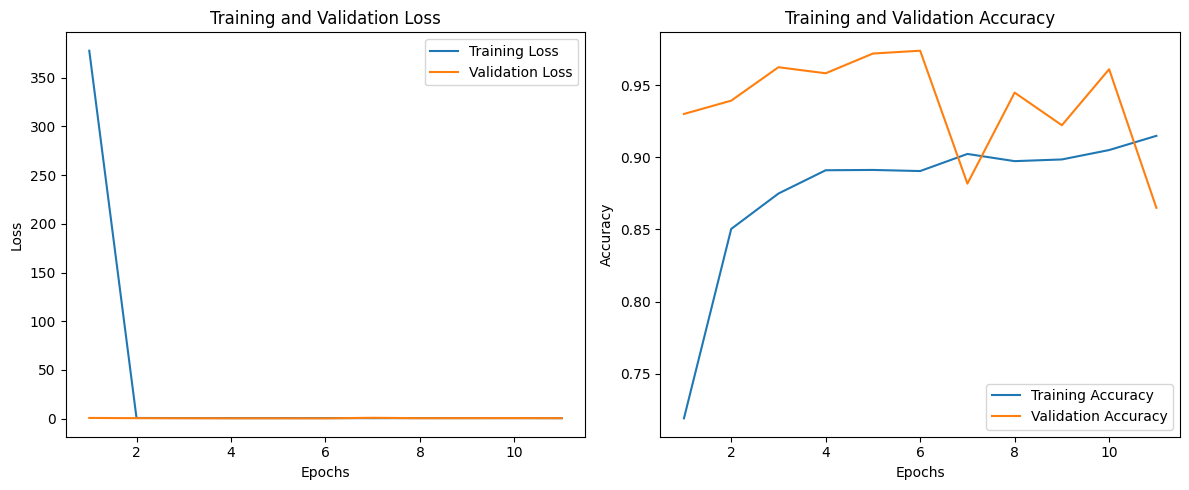

In [ ]:


# トレーニング中の損失と正解率を取得
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# グラフ化
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
